In [1]:
!pip install --upgrade gensim 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 9.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
!pip install --upgrade sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=a285ed581d50f6d14376a5a29ffe661dc92eda3ce96cbdec584f4ac7ae88b343
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%load_ext tensorboard

import io
import re
import string
import tqdm

import gensim

import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import DBSCAN

#Dimension reduction and clustering libraries
#try:
#  import umap
#except:
!pip install umap-learn
#import umap
import umap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 29.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=379429a789e8ec0062434341ebeee03da0d62d4a3dfd5a692502f5030eb0991a
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=fa447b2af3bdc0a01d72d4ad9acbcca2bb5d0ace59ec55e1ca71d615cb279382
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [5]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Define the vocabulary size and number of words in a sequence.
vocab_size = 8192
sequence_length = 20
num_ns = 3
embedding_dim = 200
#distance_threshold = 0.1 #when records are considered problematic - or the same
alphaD2V = 0.25
min_alphaD2V=0.00025
epochsD2V = 500

epsDB = 0.4

#dataFileName = r'/content/drive/MyDrive/S1-S18 Test Samples/S5G.txt'
#truthFileName = r'/content/drive/MyDrive/S1-S18 Test Samples/truthABCgoodDQ.txt'

dataFileName = r'/content/drive/MyDrive/S1-S18 Test Samples/S5G.txt'
truthFileName = r'/content/drive/MyDrive/S1-S18 Test Samples/truthABCgoodDQ.txt'



In [ ]:
#import sys
import time
import datetime
from csv import reader
#import DWM10_Parms
#import DWM100_ReportData
#logFile = open(r'Embedding_Log.txt', 'w')


def generateMetrics(linkIndex, name = '', logFileName = r'Embedding_Log.txt'):
    logFile = open(logFileName, 'a')
    #logFile = DWM10_Parms.logFile
    print(f'\n>>Starting DWM99: {name}')
    print(f'\n-----------------------\n>>Starting DWM99: {name}', file=logFile)
    print(datetime.datetime.now())
    print(datetime.datetime.now(), file=logFile)
    print(f'num_ns={num_ns}, embedding_dim={embedding_dim}, epochsD2V={epochsD2V}, alphaD2V={alphaD2V}, min_alphaD2V={min_alphaD2V}, epsDB={epsDB}')
    print(f'num_ns={num_ns}, embedding_dim={embedding_dim}, epochsD2V={epochsD2V}, alphaD2V={alphaD2V}, min_alphaD2V={min_alphaD2V}, epsDB={epsDB}',
          file=logFile)
    
    #truthFileName = DWM10_Parms.truthFileName
    print('Data File Name=', dataFileName)
    print('Data File Name=', dataFileName, file=logFile)
    print('Truth File Name=', truthFileName)
    print('Truth File Name=', truthFileName, file=logFile)    
    def countPairs(dict):
        totalPairs = 0
        for cnt in dict.values():
            pairs = cnt*(cnt-1)/2
            totalPairs +=pairs
        return totalPairs
    erDict = {}
    for refID in linkIndex:
        clusterID = linkIndex[refID]
        erDict[refID] = (clusterID,'x')
        
    #print(f"erDict is {erDict}")    
        
    truthFile = open(truthFileName,'r')
    line = (truthFile.readline()).strip()
    line = (truthFile.readline()).strip()
    while line != '':
        part = line.split(',')
        recID = part[0].strip().lower()
        truthID = part[1].strip().lower()
        if recID in erDict:
            oldPair = erDict[recID]
            clusterID = oldPair[0]
            newPair = (clusterID, truthID)
            erDict[recID] = newPair
        line = (truthFile.readline()).strip()
    
    #print(f"erDict is {erDict}")
    
    linkedPairs = {}
    equivPairs = {}
    truePos = {}
    clusterIndex = []
    for pair in erDict.values():
        clusterID = pair[0]
        truthID = pair[1]
        if pair in truePos:
            cnt = truePos[pair]
            aPair = [pair[0],truthID]
            clusterIndex.append(aPair)                        
            cnt +=1
            truePos[pair] = cnt            
        else:
            truePos[pair] = 1
        if clusterID in linkedPairs:
            cnt = linkedPairs[clusterID]
            cnt +=1
            linkedPairs[clusterID] = cnt
        else:
            linkedPairs[clusterID] = 1
        if truthID in equivPairs:
            cnt = equivPairs[truthID]
            cnt +=1
            equivPairs[truthID] = cnt
        else:
            equivPairs[truthID] = 1   
    # End of counts
    #print(f"\n-----\n{linkedPairs}\n-------\n{equivPairs}")
    L = countPairs(linkedPairs)
    E = countPairs(equivPairs)
    TP = countPairs(truePos)
    FP = float(L-TP)
    FN = float(E-TP)
    if L > 0:
        precision = round(TP/float(L),4)
    else:
        precision = 1.00
    if E > 0:
        recall = round(TP/float(E),4)
    else:
        recall = 1.00
    try:  
        fmeas = round((2*precision*recall)/(precision+recall),4)
    except:
        fmeas = -1
      
    # for report process
    #DWM10_Parms.precision = precision
    #DWM10_Parms.recall = recall
    #DWM10_Parms.fmeasure = fmeas
    #DWM10_Parms.truePairs = TP
    #DWM10_Parms.expectedPairs = E
    #DWM10_Parms.linkedPairs = L
    
    print('True Pairs =',TP)
    print('True Pairs =',TP, file=logFile)
    print('Expected Pairs =',E)
    print('Expected Pairs =',E, file=logFile)
    print('Linked Pairs =',L)
    print('Linked Pairs =',L, file=logFile)
    print('Precision=',precision)
    print('Precision=',precision, file=logFile)
    print('Recall=', recall)
    print('Recall=', recall, file=logFile)
    print('F-measure=', fmeas)
    print('F-measure=', fmeas, file=logFile)
    
    return


In [6]:
path_to_file = dataFileName
with open(path_to_file) as f: 
    lines = f.read().splitlines()
for line in lines:
    print(line)


RecID,fname,lname,mname,address,city,state,zip,ssn
A944634,IAN,AADLAND,LARS,29021  HIGH SIERRA TRL   ,SANTA CLARITA,CA,91390,490-46-2048
A755471,MYRA,AARGAARD-ESPERSEN,,1224 MAGNOLIA ST,WINSTON SALEM,NC,27103,117-15-8521
A912696,MYRA,AAARGAARD-ESPERSEN,,1224 MAGNOLIA ST,WINSTON SALEM,NC,27103,117158521
A813025,ALLEN,AARON,IKAIKA,3830 COUNTRY CLUB RD # J,WINSTON SALEM,NC,27104,
A824917,ANDREW,AARON,STEPHEN,2475 spicewood dr,winston salem,nc,27106,601-70-6106
A875214,ANDREEW,AARON,STEPHEN,2475 SPICEWOOD DR,WINSTON SALEM,NC,27106,601-70-6106
A914099,,AARON,D,1117 E SEVENTEENTH ST,WINSTON SALEM,NC,27105,636-32-8781
A812219,CELIA,AARON,,1106  LASSEN DR   ,HANFORD,CA,93230,344-37-4232
A963930,CHRISTOPHER,AARON,,2013 WILLIAMSBURG MANOR CT,WINSTON SALEM,NC,27103,741-75-7354
A776838,DAVIS,AAARON,SCOTT,3211 KINNAMON RD,WINSTON SALEM,NC,27104,834-59-6144
A844925,DAVIS,AARON,SCOTT,3211 KINNAMON RD,WINSTON SALEM,NC,27104,834-59-6144
A770538,DONALD,AARON,DWIGHT,6965 WEST RD,WALNUT COVE,NC,27052,1315

In [22]:
print(len(lines))

1001


In [7]:
import pandas as pd
df = pd.read_csv (truthFileName)

print(df)


df.loc[df['RecID'] == "A750205"].iloc[0]["idtruth"]



          RecID  idtruth
0       A944634        1
1       B943052        1
2       B890273        2
3       C627608        2
4       C627609        2
...         ...      ...
886640  C999995   253372
886641  C999996   253373
886642  C999997   253374
886643  C999998   253375
886644  C999999   253376

[886645 rows x 2 columns]


40

In [31]:
path_to_file1 = truthFileName
with open(path_to_file1) as f1: 
    trt_lines = f1.read().splitlines()
for line in trt_lines[:10]:
    print(line)
#for line in lines:
 #   print(line)

#for line in lines:
#    print(line)

RecID,IdTruth
A912969,1
A915784,1
A933400,1
A935183,1
A968925,1
A969374,1
A993286,1
A994281,1
B898198,1


In [8]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    glued = tf.strings.regex_replace(lowercase, r"-", r"")
    ret = tf.strings.regex_replace(glued,
                                  '[%s]' % re.escape(string.punctuation), ' ')
    cons = tf.strings.regex_replace(ret, '  +', ' ')
    #print(f"----- {input_data} \n")
    global jimmy
    jimmy = cons
    return cons

In [9]:
#text_ds = tf.data.TextLineDataset(path_to_file)
text_ds = tf.data.Dataset.from_tensor_slices(lines[1:])
#print(text_ds)
for line in text_ds.take(5):
    print(line.numpy())

clean_text_ds = custom_standardization(lines[1:])

print('\n')
for line in clean_text_ds[:5]:
    print(line.numpy())

#documents = [gensim.models.doc2vec.TaggedDocument(line.decode().split(), 
#                                                  [line.decode().split()[0]]) 
#                                                     for line in clean_text_ds.numpy()]
                                                
                                        

b'A944634,IAN,AADLAND,LARS,29021  HIGH SIERRA TRL   ,SANTA CLARITA,CA,91390,490-46-2048'
b'A755471,MYRA,AARGAARD-ESPERSEN,,1224 MAGNOLIA ST,WINSTON SALEM,NC,27103,117-15-8521'
b'A912696,MYRA,AAARGAARD-ESPERSEN,,1224 MAGNOLIA ST,WINSTON SALEM,NC,27103,117158521'
b'A813025,ALLEN,AARON,IKAIKA,3830 COUNTRY CLUB RD # J,WINSTON SALEM,NC,27104,'
b'A824917,ANDREW,AARON,STEPHEN,2475 spicewood dr,winston salem,nc,27106,601-70-6106'


b'a944634 ian aadland lars 29021 high sierra trl santa clarita ca 91390 490462048'
b'a755471 myra aargaardespersen 1224 magnolia st winston salem nc 27103 117158521'
b'a912696 myra aaargaardespersen 1224 magnolia st winston salem nc 27103 117158521'
b'a813025 allen aaron ikaika 3830 country club rd j winston salem nc 27104 '
b'a824917 andrew aaron stephen 2475 spicewood dr winston salem nc 27106 601706106'


In [ ]:
clean_text_ds[1].numpy()

b'a755471 myra aargaardespersen 1224 magnolia st winston salem nc 27103 117158521'

In [11]:
cluster_ids = []
for line1 in clean_text_ds.numpy():
  id = tf.strings.upper(line1.decode().split()[0]).numpy().decode("ascii")
  cl = df.loc[df['RecID'] == id].iloc[0]["idtruth"]
  cluster_ids.append(cl)
  #print(id)

In [33]:
cluster_ids

[1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 26,
 27,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 34,
 34,
 34,
 35,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 38,
 38,
 38,
 38,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 44,
 44,
 44,
 44,
 45,

In [ ]:
#cc = np.concatenate([np.reshape(c1, (len(c1), 1)), np.reshape(c2, (len(c2), 1))], axis=1)

In [ ]:

model = gensim.models.doc2vec.Doc2Vec(vector_size=embedding_dim, 
                                      min_count=2, 
                                      epochs= epochsD2V, 
                                      alpha = alphaD2V, 
                                      min_alpha=min_alphaD2V
                                     )
model.build_vocab(documents)
model.train(documents, 
            total_examples=model.corpus_count, 
            epochs=model.epochs
           )

In [ ]:
model.wv

In [ ]:
model.dv

In [ ]:
out_v = io.open('RecVectorsD2V.tsv', 'w', encoding='utf-8')
out_m = io.open('RecMetadataD2V.tsv', 'w', encoding='utf-8')

recids = []
vectors = []
i = 0 #needed to keep trak of rec and index

for line in clean_text_ds.numpy():
    rec = line.decode().split()[0]
    out_m.write(f"{rec}\n")
    recids.append(rec)
    
    #vec = weights[seq[0]]
    #out_v.write('\t'.join([str(x) for x in vec]))
    vec = model.dv.get_vector(rec)
    i = i + 1
    out_v.write('\t'.join([str(x) for x in vec]))
    out_v.write("\n")
    vectors.append(vec)

out_v.close()
out_m.close()

In [ ]:
#model.dv.get_index()
#for i, rec in enumerate(recids[:10]):
#    print(f"{rec} )

In [ ]:
print(np.shape(vectors))
dimReductor = umap.UMAP(random_state=SEED, 
                               n_neighbors = 5, 
                               n_components = 2,
                               min_dist = 0.7)
standard_embedding = dimReductor.fit_transform(vectors)
np.shape(standard_embedding)

(3004, 200)


(3004, 2)

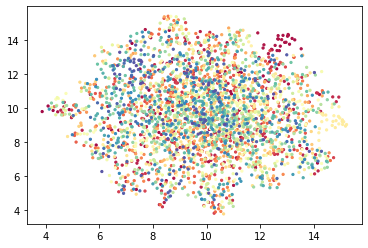

In [ ]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=cluster_id, s=5, cmap='Spectral');

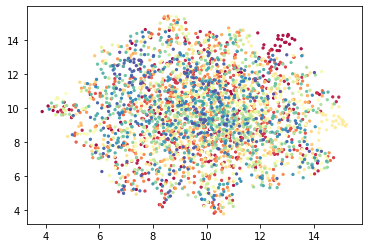

In [ ]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=np.arange(len(vectors)), s=5, cmap='Spectral');

In [12]:
pip install kmapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.0 MB/s 


In [13]:
import numpy as np
import pandas as pd
import kmapper as km
from kmapper import Cover, jupyter
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster

def compute_embedding (clean_text):
    documents = [gensim.models.doc2vec.TaggedDocument(line.decode().split(), 
                                                  [line.decode().split()[0]]) 
                                                     for line in clean_text]

    model = gensim.models.doc2vec.Doc2Vec(vector_size=embedding_dim, 
                                      min_count=2, 
                                      epochs= epochsD2V, 
                                      alpha = alphaD2V, 
                                      min_alpha=min_alphaD2V
                                     )
    model.build_vocab(documents)
    model.train(documents, 
            total_examples=model.corpus_count, 
            epochs=model.epochs
           )

    out_v = io.open('RecVectorsD2V.tsv', 'w', encoding='utf-8')
    out_m = io.open('RecMetadataD2V.tsv', 'w', encoding='utf-8')

    recids = []
    vectors = []
    i = 0 #needed to keep trak of rec and index

    for line in clean_text:
        rec = line.decode().split()[0]
        out_m.write(f"{rec}\n")
        recids.append(rec)
    
        #vec = weights[seq[0]]
        #out_v.write('\t'.join([str(x) for x in vec]))
        vec = model.dv.get_vector(rec)
        i = i + 1
        out_v.write('\t'.join([str(x) for x in vec]))
        out_v.write("\n")
        vectors.append(vec)

    out_v.close()
    out_m.close() 
    return recids,vectors

def compute_graph(vectors):
    print(np.shape(vectors))
    dimReductor = umap.UMAP(random_state=SEED, 
                               n_neighbors = 5, 
                               n_components = 2,
                               min_dist = 0.7)
    standard_embedding = dimReductor.fit_transform(vectors)
    print(np.shape(standard_embedding))



    mapper = km.KeplerMapper(verbose=0)
    #projected_X = mapper.fit_transform(standard_embedding)
    graph = mapper.map(standard_embedding,
                   X=np.array(vectors),
                   clusterer=cluster.AgglomerativeClustering(n_clusters=3,
                                                             linkage="complete",
                                                             affinity="cosine"),
                   cover=Cover(perc_overlap=0.33))
    return graph

In [14]:
recids,vectors = compute_embedding(clean_text_ds.numpy())

In [37]:
graph = compute_graph (vectors)

(1000, 200)
(1000, 2)


In [ ]:
for node in graph['nodes']:
  print(graph['nodes'][node])

[787, 811, 1044, 1623, 2166]
[38]
[1271, 1273]
[787, 1044, 1623, 2166]
[1600, 2918]
[7, 21, 30, 33, 37]
[102, 357, 569, 570, 1020, 1340, 1586, 1634, 1641, 1831, 1879, 2562, 2564, 2580]
[1600, 2824, 2918]
[8, 21, 30, 37]
[102, 569, 570, 1020, 1149, 1340, 1586]
[417, 560, 583, 891, 1240, 1276, 1288, 1289, 1381, 1413, 1487, 1510, 1879, 1884, 2297, 2348, 2389, 2526, 2562, 2564, 2580, 2674, 2783]
[357, 1193, 1275, 1591, 1641, 1831, 2265, 2266, 2668, 2737, 2757]
[1193, 1510, 2266]
[414, 417]
[1275]
[144, 268, 520, 1105, 1354, 1518, 1653, 2133, 2772]
[391, 392]
[516, 517, 518]
[36, 144, 212, 268, 391, 392, 547, 641, 1105, 1352, 1354, 1406, 1432, 1514, 1518, 1602, 1653, 1845, 2216, 2443]
[2390]
[252]
[38, 45, 46, 47, 96, 104, 209, 562, 651, 654, 655, 787, 811, 1044, 1070, 1271, 1272, 1273, 1375, 1623, 1624, 1638, 1853, 1862, 1864, 2048, 2126, 2166, 2326, 2358, 2419, 2787, 2954]
[115, 252, 641, 1845, 2390]
[189, 284, 910, 2033, 2102]
[11, 51, 52, 104, 284, 562, 590, 602, 910, 1044, 1070, 1252, 

In [ ]:
graph['nodes']['cube0_cluster0']

[787, 811, 1044, 1623, 2166]

In [15]:
def count_rec_node(graph,record):
  count = 0
  for node in graph['nodes']:
    if record in graph['nodes'][node]:
      #print(graph['nodes'][node])
      count = count+len(graph['nodes'][node])
  return count

#b find the nodes that cointain record
# count the size of each node
# return the sum of all nodes
# write a loop remove all the duplicates from all nodes except one

In [ ]:
count_rec_node(graph,418)

[413, 416, 418, 469, 956, 1019, 1148, 1192, 1274, 1299, 2388, 2561, 2667, 2756, 2948]
[408, 410, 411, 412, 414, 415, 417, 418, 423, 424, 425, 426, 427, 428]
[184, 356, 418, 956, 1192, 1539, 1540, 2226, 2667]
[70, 73, 417, 418, 558, 591, 673, 986, 1024, 1025, 1036, 1156, 1401, 1403, 1433, 1453, 1744, 1944, 2133, 2137, 2156, 2157, 2216, 2226, 2268, 2779]


64

In [16]:
def seperate_data(clean_text_ds,cluster_id,embedding,recids,cluster):
  cluster_embedig = []
  common_embeding = []
  cluster_ids = []
  common_ids = []
  cluster_recds = []
  common_recds = []
  i=0
  for rec in clean_text_ds.numpy():
    if cluster == cluster_id[i]:
      cluster_recds.append(rec)
      cluster_embedig.append(embedding[i])
      cluster_ids.append(recids[i])
    else: 
      common_recds.append(rec)
      common_embeding.append(embedding[i])
      common_ids.append(recids[i])

    #id = tf.strings.upper(rec.decode().split()[0]).numpy().decode("ascii")
    #print(id)
    #print(cluster_id[i])
    i=i+1
  return np.array(cluster_recds),np.array(common_recds),cluster_ids,common_ids,np.array(cluster_embedig),np.array(common_embeding)

In [ ]:
recids,vectors = compute_embedding(clean_text_ds.numpy())


In [ ]:

clustera,common,cluster_id,common_id,cluster_embedig,common_embding = seperate_data(clean_text_ds,cluster_ids,vectors,recids,13)
fliter_recds = np.append(common,clustera[1])
clustera


array([b'a770538 donald aaron dwight 6965 west rd walnut cove nc 27052 131532482',
       b'a816319 aaron donald dwight 6965 west rd walnut cove nc 27052 131532482',
       b'a882820 donald aaron dwight 6965 west rd walnut cove nc 27052 131532482'],
      dtype='|S71')

In [ ]:
np.shape(cluster_embedig)

(3, 200)

In [17]:
beg = 0
end = 49
cluster_selc = io.open('cluster_selc.tsv'+ str(beg)+"-"+str(end), 'w', encoding='utf-8')
for id in np.unique(cluster_ids[beg:end]):
  clustera,common,cluster_id,common_id,cluster_embedig,common_embding = seperate_data(clean_text_ds,cluster_ids,vectors,recids,id)
  if np.shape(clustera)[0] == 1:
    print("cluster has 1 node",clustera)
    cluster_selc.write(str(id)+"\t"+cluster_id[0]+"\t1"+"\t0"+"\n")
  else:
    i=0
    node_counts = []
    for rec in clustera:
      filtered_vectors = np.append(common_embding,[cluster_embedig[i]],axis = 0)
      #print(np.shape(filtered_vectors)[0])
      graph = compute_graph(filtered_vectors)
      c = count_rec_node(graph,np.shape(filtered_vectors)[0]-1)
      node_counts.append(c)
      print(c)
      i=i+1
    print(node_counts,clustera)
    cluster_selc.write(str(id)+"\t"+cluster_id[np.argmax(node_counts)]+"\t"+str(len(node_counts))+"\t"+str(np.max(node_counts))+"\n")
cluster_selc.close()


cluster has 1 node [b'a944634 ian aadland lars 29021 high sierra trl santa clarita ca 91390 490462048']
(3003, 200)
(3003, 2)
92
(3003, 200)
(3003, 2)
158
[92, 158] [b'a755471 myra aargaardespersen 1224 magnolia st winston salem nc 27103 117158521'
 b'a912696 myra aaargaardespersen 1224 magnolia st winston salem nc 27103 117158521']
cluster has 1 node [b'a813025 allen aaron ikaika 3830 country club rd j winston salem nc 27104 ']
(3003, 200)
(3003, 2)
128
(3003, 200)
(3003, 2)
261
[128, 261] [b'a824917 andrew aaron stephen 2475 spicewood dr winston salem nc 27106 601706106'
 b'a875214 andreew aaron stephen 2475 spicewood dr winston salem nc 27106 601706106']
cluster has 1 node [b'a914099 aaron d 1117 e seventeenth st winston salem nc 27105 636328781']
cluster has 1 node [b'a812219 celia aaron 1106 lassen dr hanford ca 93230 344374232']
cluster has 1 node [b'a963930 christopher aaron 2013 williamsburg manor ct winston salem nc 27103 741757354']
(3003, 200)
(3003, 2)
188
(3003, 200)
(3003

In [ ]:
import pandas as pd

df = pd.DataFrame(node_counts)

#df.to_csv('file_name.csv', encoding='utf-8')
df.to_csv(r'C:\Users\madha\downloads\new1.csv', encoding='utf-8')

#if i==0:
#  df.to_csv(r'C:\Users\madha\downloads\new.csv', mode='a', index=False )
#else:
#  df.to_csv(r'C:\Users\madha\downloads\new.csv', mode='a', index=False, header=None)
#print('Dataframe:\n', df)

In [ ]:
recids,vectors = compute_embedding(fliter_recds)

In [ ]:
graph = compute_graph(vectors)

(3002, 200)
(3002, 2)
KeplerMapper(verbose=2)
Mapping on data shaped (3002, 200) using lens shaped (3002, 2)

Minimal points in hypercube before clustering: 3
Creating 100 hypercubes.
Cube_0 is empty.

   > Found 3 clusters in hypercube 1.
   > Found 3 clusters in hypercube 2.
   > Found 3 clusters in hypercube 3.
   > Found 3 clusters in hypercube 4.
   > Found 3 clusters in hypercube 5.
   > Found 3 clusters in hypercube 6.
   > Found 3 clusters in hypercube 7.
   > Found 3 clusters in hypercube 8.
   > Found 3 clusters in hypercube 9.
   > Found 3 clusters in hypercube 10.
   > Found 3 clusters in hypercube 11.
   > Found 3 clusters in hypercube 12.
   > Found 3 clusters in hypercube 13.
Cube_14 is empty.

   > Found 3 clusters in hypercube 15.
   > Found 3 clusters in hypercube 16.
   > Found 3 clusters in hypercube 17.
   > Found 3 clusters in hypercube 18.
   > Found 3 clusters in hypercube 19.
   > Found 3 clusters in hypercube 20.
   > Found 3 clusters in hypercube 21.
   > Fou

In [ ]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap


In [ ]:
pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 855 kB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59437 sha256=0f4170b1f4a5cac2ca2f83692aed9657bc6f91f61f3126ab332ab3148ff73ae9
  Stored in directory: /root/.cache/pip/wheels/b5/b7/80/333a5c3312ed4cd54f5d5b869868c14e0c6002cb5c7238b52d
Successfully built datashape


In [ ]:
import umap.plot

In [ ]:
pip install kmapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import kmapper as km
from kmapper import Cover, jupyter

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster

In [ ]:
mapper = km.KeplerMapper(verbose=2)

#projected_X = mapper.fit_transform(standard_embedding)
graph = mapper.map(standard_embedding,
                   X=np.array(vectors),
                   clusterer=cluster.AgglomerativeClustering(n_clusters=3,
                                                             linkage="complete",
                                                             affinity="cosine"),
                   cover=Cover(perc_overlap=0.33))
    

KeplerMapper(verbose=2)
Mapping on data shaped (3004, 200) using lens shaped (3004, 2)

Minimal points in hypercube before clustering: 3
Creating 100 hypercubes.
   > Found 3 clusters in hypercube 0.
   > Found 3 clusters in hypercube 1.
   > Found 3 clusters in hypercube 2.
   > Found 3 clusters in hypercube 3.
Cube_4 is empty.

   > Found 3 clusters in hypercube 5.
   > Found 3 clusters in hypercube 6.
   > Found 3 clusters in hypercube 7.
   > Found 3 clusters in hypercube 8.
   > Found 3 clusters in hypercube 9.
   > Found 3 clusters in hypercube 10.
   > Found 3 clusters in hypercube 11.
   > Found 3 clusters in hypercube 12.
   > Found 3 clusters in hypercube 13.
   > Found 3 clusters in hypercube 14.
   > Found 3 clusters in hypercube 15.
   > Found 3 clusters in hypercube 16.
   > Found 3 clusters in hypercube 17.
   > Found 3 clusters in hypercube 18.
   > Found 3 clusters in hypercube 19.
   > Found 3 clusters in hypercube 20.
Cube_21 is empty.

   > Found 3 clusters in hyper

In [ ]:
cluster_id[2323]

2252

In [ ]:
np.shape(standard_embedding)

(3004, 2)

In [ ]:
np.shape(recids)

(3004,)

In [ ]:
np.array(cluster_id).shape

(3004,)

In [ ]:
_ = mapper.visualize(graph,
                        X=np.array(vectors),
                        X_names=np.array(cluster_id),
                       # path_html=r"C:\Users\madha\output\newsgroups20.html",
                        path_html=r"C:\Users\madha\newsgroups20.html",
                        lens = standard_embedding,
                        lens_names=["U-Map x","U-Map y"],
                        title="Some thing",
                        custom_tooltips= np.array(cluster_id),
                        include_searchbar=True,
                        #color_values=cluster_id,
                        #color_function_name='cluster'
                     )



Wrote visualization to: C:\Users\madha\newsgroups20.html


In [ ]:
jupyter.display(r"C:\Users\madha\newsgroups20.html")

/usr/local/lib/python3.7/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [ ]:
epsDB = 19
clusterer = DBSCAN(eps = epsDB, min_samples=1)
clusterer.fit_predict(vectors)

clustererUMAP = DBSCAN(eps = epsDB, min_samples=1)
#clustererUMAP.fit_predict(standard_embedding)

print(clusterer.labels_.max())
#print(clustererUMAP.labels_.max())
#clusterer.labels_

811


In [ ]:
linkRecIds = {} #keep the links between rec ids

#get unassigned records
print(f"-1 --------------")
idxSet = np.where(clusterer.labels_ == -1)[0]
for idx in idxSet:
    linkRecIds[recids[idx]] = recids[idx]
    print(f"{lines[idx + 1]} - ")#{clusterer.probabilities_[idx]}")
    
for cl in range(0, clusterer.labels_.max()+1):
    print(f"{cl} --------------")
    idxSet = np.where(clusterer.labels_ == cl)[0]
    refID = idxSet[0] #use this for all
    for idx in idxSet:
        linkRecIds[recids[idx]] = recids[refID]
        print(f"{lines[idx + 1]} - ")#{clusterer.probabilities_[idx]}")

-1 --------------
0 --------------
A912969,barbaar,myers-christian,3536,N,BERLIN,AVE,FRESNO,,CA,93722,Po,Box,5991,fresno,,ca,93755,010-52-5974,1936 - 
1 --------------
A915784,b,chavez,9247,TOBIAES,AVE,PNORAMA,CITY,,CALIFORNIA,91402,pomst,office,4601,Panorama,City,,California,91412,10525974,1936 - 
2 --------------
A933400,barby,chavez,11881,GULF,POINTE,DR,APT,E38,HOUSTON,,TX,77089,,,010-55-2974,19360814, - 
3 --------------
A935183,barbara,chavez,11881,GULF,POINTE,DRIV,APT,E38,HOUSTON,,TX,77089,,,10525974,13376, - 
4 --------------
A968925,CHAVEZ,2943,N,COTTONWOOD,ST,WUNIT,3,Orange,,Ca,92865,,,,, - 
5 --------------
A969374,brabara,chavez,2943,n,cottonwood,st,unit,3,Orangec,,Ca,92865,,,100525974,, - 
6 --------------
A993286,chavez,4149,WALSH,LN,GRAQND,PRAIRIE,,TEXAS,75052,OFFICE,BOX,54331,grand,prairie,,tx,75054,10525947, - 
7 --------------
A994281,barbie,chavze,11R881,GULF,POINTE,DR,APT,E38,HOUSTON,,TX,77089,,,,, - 
A919621,MARCELA,VILLA,18725,E,LINFIELD,ST,Azusa,,Ca,91702,,,105545

In [ ]:
linkRecIdsUMAP = {} #keep the links between rec ids

#get unassigned records
print(f"-1 --------------")
idxSet = np.where(clustererUMAP.labels_ == -1)[0]
for idx in idxSet:
    linkRecIdsUMAP[recids[idx]] = recids[idx]
    print(f"{lines[idx + 1]} - ")#{clustererUMAP.probabilities_[idx]}")
    
for cl in range(0, clustererUMAP.labels_.max()+1):
    print(f"{cl} --------------")
    idxSet = np.where(clustererUMAP.labels_ == cl)[0]
    refID = idxSet[0] #use this for all
    for idx in idxSet:
        linkRecIdsUMAP[recids[idx]] = recids[refID]
        print(f"{lines[idx + 1]} - ")#{clustererUMAP.probabilities_[idx]}")

-1 --------------
0 --------------
A944634,IAN,AADLAND,LARS,29021  HIGH SIERRA TRL   ,SANTA CLARITA,CA,91390,490-46-2048 - 
A824917,ANDREW,AARON,STEPHEN,2475 spicewood dr,winston salem,nc,27106,601-70-6106 - 
A875214,ANDREEW,AARON,STEPHEN,2475 SPICEWOOD DR,WINSTON SALEM,NC,27106,601-70-6106 - 
A914099,,AARON,D,1117 E SEVENTEENTH ST,WINSTON SALEM,NC,27105,636-32-8781 - 
A812219,CELIA,AARON,,1106  LASSEN DR   ,HANFORD,CA,93230,344-37-4232 - 
A830349,LLOYD,AARON,DEAN,2475 SPICEWOOD DR,WINSTON SALEM,NC,27106,456182098 - 
A956296,Lloyd,Aaron,D,2475 SPICEWOOD DR,WINSTON SALEM,NC,27106,456-18-2098 - 
A956423,LLOYD,AAARON,DEAN,2475 SPICEWOOD DR,WINSTON SALEM,NC,27106,456-18-2098 - 
A985464,LLOYD,AARON,DEAN,2475 SPICEWOOD DR,WINSTON SALEM,NC,27106, - 
A780828,LORI,AARON,FRANKLIN,5010 TUTELO TRL,WINSTON SALEM,NC,27127,214-83-9125 - 
A887611,LORI,AARON,FRANKLIN,5010 TUTELO TRL,WINSTON SALEM,NC,27127,214839125 - 
A970774,LORI,AARON,FRANKLIN,5010 TUTELO TRL,WINSTON SALEM,NC,27127,214-83-9125 - 
A90

In [ ]:
#generateMetrics(linkRecIdsBoth, name = 'intersection, D2V')
generateMetrics(linkRecIds, name = f'D2V,  dbscan')
#generateMetrics(linkRecIdsUMAP, name = f'D2V UMAP, dbscan')
#generateMetrics(linkRemoved)


>>Starting DWM99: D2V,  dbscan
2022-04-19 21:07:30.669320
num_ns=3, embedding_dim=50, epochsD2V=500, alphaD2V=0.25, min_alphaD2V=0.00025, epsDB=15
Data File Name= /content/drive/MyDrive/Embedding/S1-S18 Test Samples/S8P.txt
Truth File Name= /content/drive/MyDrive/Embedding/S1-S18 Test Samples/truthABCpoorDQ.txt
True Pairs = 5.0
Expected Pairs = 2811.0
Linked Pairs = 32.0
Precision= 0.1562
Recall= 0.0018
F-measure= 0.0036
